In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Predictions for Chicago South

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import open_cp.sources.chicago as chicago
import geopandas as gpd
import numpy as np

# Wherever "generate_sources.py" put files
datadir = os.path.join("..", "..", "..", "..", "..", "Data", "generated")

In [3]:
data = gpd.read_file(os.path.join(datadir,"chicago_old_South"))
data = data[data.crime == "BURGLARY"]
# US Illinois, but in meters: http://spatialreference.org/ref/epsg/2790/
data = data.to_crs({"init":"epsg:2790"})

# Convert to our format

In [4]:
# Convert timestamps from strings and sort
data.timestamp = data.timestamp.map(chicago.date_from_iso)
data.sort_values("timestamp", inplace=True)

In [5]:
import open_cp
import open_cp.predictors

In [6]:
points = open_cp.TimedPoints.from_coords(data.timestamp,
        data.geometry.map(lambda pt : pt.coords[0][0]),
        data.geometry.map(lambda pt : pt.coords[0][1]))

In [7]:
min(points.timestamps), max(points.timestamps)

(numpy.datetime64('2010-09-13T19:00:00.000'),
 numpy.datetime64('2013-04-16T00:30:00.000'))

# Other setup

*TODO:* Move some of this into the `chicago` package...

In [8]:
sides = gpd.read_file(os.path.join(datadir,"Chicago_Sides"))

side_shape = sides[sides.side == "South"].unary_union

side = gpd.GeoDataFrame()
side.geometry = [side_shape]
side.crs = sides.crs

In [9]:
cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", cdict)

# Recreate Adepeju, Rosser and Cheng:

- Data in just Chicago South side
- Burglary data
- From 1st March 2011 to 6th January 2012
- Evaluate 28th September 2011 – 6th January 2012

## Plot the crime

In [10]:
import open_cp.naive

predictor = open_cp.naive.CountingGridKernel(250)
time_range_mask = ( (points.timestamps >= np.datetime64("2011-03-01T00:00")) &
    (points.timestamps <= np.datetime64("2012-01-07T00:00")) )
predictor.data = points[time_range_mask]
#predictor.region = predictor.data.bounding_box
#predictor.region += open_cp.Point(1000, 150)
risk = predictor.predict()
print("Number of data points:", predictor.data.number_data_points)

Number of data points: 3395


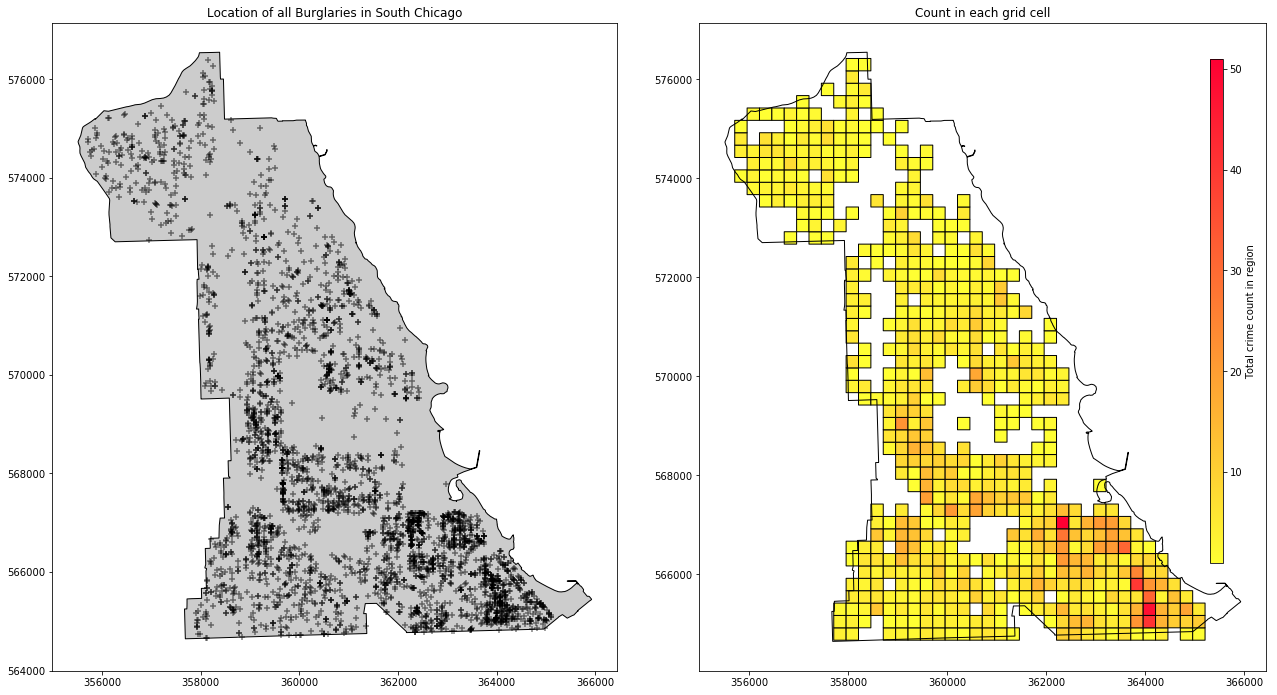

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))
for a in ax:
    a.set_aspect(1)

side.to_crs(data.crs).plot(ax=ax[0], color="black", alpha=0.2)
ax[0].scatter(*predictor.data.coords, marker="+", color="black", alpha=0.5)

side.to_crs(data.crs).plot(ax=ax[1], color="black", alpha=0)
matrix = np.ma.masked_where(risk.intensity_matrix==0, risk.intensity_matrix)
mappable = ax[1].pcolor(*risk.mesh_data(), matrix, cmap=yellow_to_red, edgecolor="black", linewidth=1)

# Tedious graph layout...
cax = fig.add_axes([0.9, 0.2, 0.01, 0.7])
cbar = fig.colorbar(mappable, orientation="vertical", cax=cax)
cbar.set_label("Total crime count in region")

ax[0].set_position([0,0.05,0.45,0.9])
ax[1].set_position([0.5,0.05,0.45,0.9])
ax[0].set_title("Location of all Burglaries in South Chicago")
ax[1].set_title("Count in each grid cell")

None

# Using "masked grids" and predictions

We clip our grid to just cover the geographic region of interest, and then make two "naive" predictions:

- Use the `scipy` Gaussidan KDE method
- Use the `naive` predictor-- just base the risk on a count of past crime in that grid cell.

In [27]:
import open_cp.evaluation
import open_cp.geometry
import open_cp.plot

import importlib
importlib.reload(open_cp.predictors)

<module 'open_cp.predictors' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\PredictCode\\open_cp\\predictors.py'>

In [28]:
outline = side.to_crs(data.crs).geometry[0]
grid = open_cp.data.Grid(xsize=250, ysize=250, xoffset=0, yoffset=0)
masked_grid = open_cp.geometry.mask_grid_by_intersection(outline, grid)

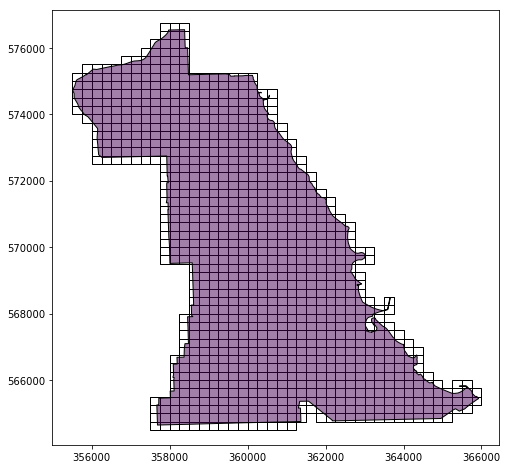

In [29]:
fig, ax  = plt.subplots(figsize=(8,8))
side.to_crs(data.crs).plot(ax=ax)

pc = open_cp.plot.patches_from_grid(masked_grid)
ax.add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
None

In [30]:
training_time_range_mask = ( (points.timestamps >= np.datetime64("2011-03-01T00:00")) &
    (points.timestamps <= np.datetime64("2011-09-28T00:00")) )

kde_predictor = open_cp.naive.ScipyKDE()
kde_predictor.data = points[training_time_range_mask]
kde_risk = open_cp.predictors.grid_prediction(kde_predictor.predict(), masked_grid)

In [32]:
naive_predictor = open_cp.naive.CountingGridKernel(masked_grid.xsize, region = masked_grid.region())
naive_predictor.data = points[training_time_range_mask]
naive_risk = naive_predictor.predict()
naive_risk.mask_with(masked_grid)

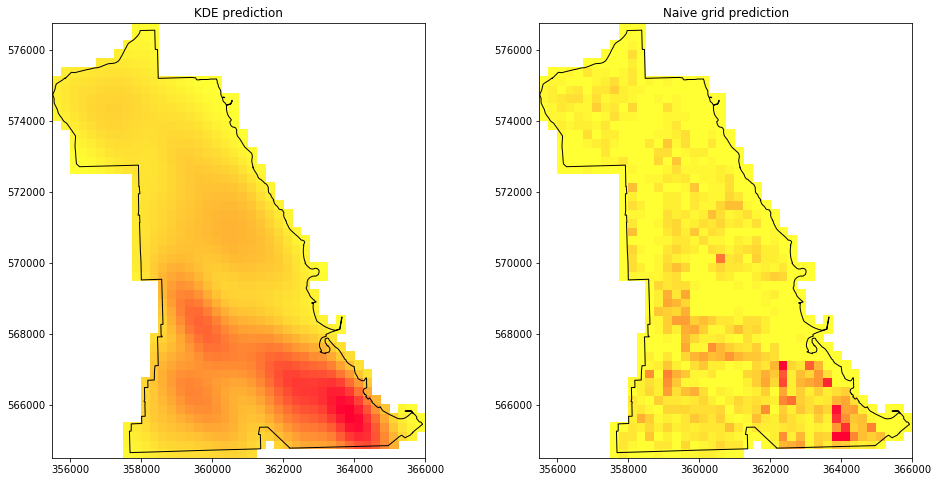

In [54]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    side.to_crs(data.crs).plot(ax=a, color="black", alpha=0)
    
ax[0].pcolormesh(*kde_risk.mesh_data(), kde_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].pcolormesh(*naive_risk.mesh_data(), naive_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("KDE prediction")
ax[1].set_title("Naive grid prediction")
None

### Visualise the top 10% coverage in each case

Note that the scaling of colours is _not_ the same as in the above plots (it has been renormalised.)

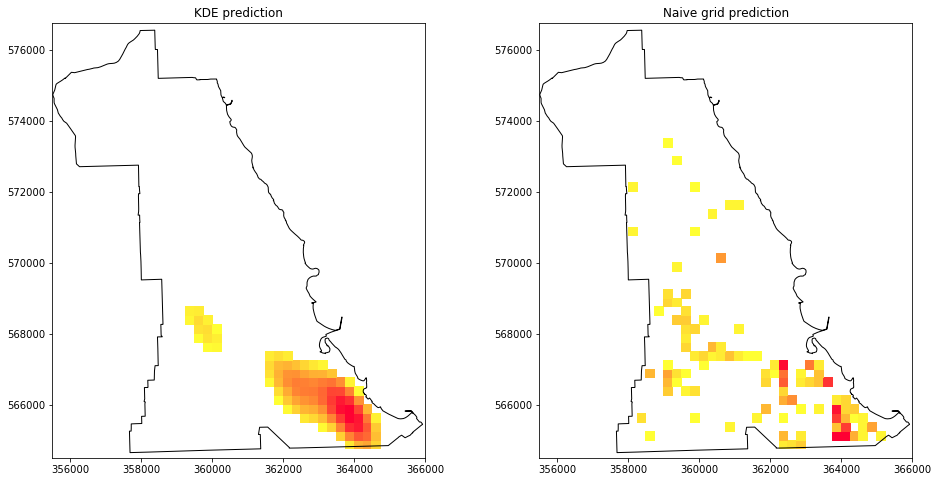

In [34]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    side.to_crs(data.crs).plot(ax=a, color="black", alpha=0)
    
mat = kde_risk.intensity_matrix.copy()
mask = open_cp.evaluation.top_slice(mat, .1)
mat.mask |= ~mask
ax[0].pcolormesh(*kde_risk.mesh_data(), mat, cmap=yellow_to_red)
mat = naive_risk.intensity_matrix.copy()
mask = open_cp.evaluation.top_slice(mat, .1)
mat.mask |= ~mask
ax[1].pcolormesh(*kde_risk.mesh_data(), mat, cmap=yellow_to_red)
ax[0].set_title("KDE prediction")
ax[1].set_title("Naive grid prediction")
None

# Prohotspot / Retrohotspot

Here we use the "Prospective hotspot" and "Retrospective hotspot" algorithms.

- The Prospective hotspot algorithm is essentially a grid-based, space and time KDE method.
   - We use the default time unit of a "week" and a bandwidth of 8 weeks
   - We adjust the space bandwidth to 2 grid cells-- 500 meters
   
- The retrospective hotspot algorithm is essentially a grid-based, space-only KDE method.
   - We adjust the space bandwidth to 500 meters

In [57]:
import open_cp.prohotspot
import open_cp.retrohotspot
importlib.reload(open_cp.prohotspot)
importlib.reload(open_cp.retrohotspot)

<module 'open_cp.retrohotspot' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\PredictCode\\open_cp\\retrohotspot.py'>

In [68]:
prohotspot_predictor = open_cp.prohotspot.ProspectiveHotSpot(grid=masked_grid)
prohotspot_predictor.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]
prohotspot_predictor.weight = open_cp.prohotspot.ClassicWeight()
prohotspot_predictor.weight.space_bandwidth = 2
prohotspot_risk = prohotspot_predictor.predict(np.datetime64("2011-09-28T00:00"), np.datetime64("2011-09-28T00:00"))
prohotspot_risk.mask_with(masked_grid)

In [69]:
retrohotspot_predictor = open_cp.retrohotspot.RetroHotSpotGrid(grid=masked_grid)
retrohotspot_predictor.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]
retrohotspot_predictor.weight = open_cp.retrohotspot.Quartic(bandwidth=500)
retrohotspot_risk = retrohotspot_predictor.predict(np.datetime64("2011-09-28T00:00"), np.datetime64("2011-09-28T00:00"))
retrohotspot_risk.mask_with(masked_grid)

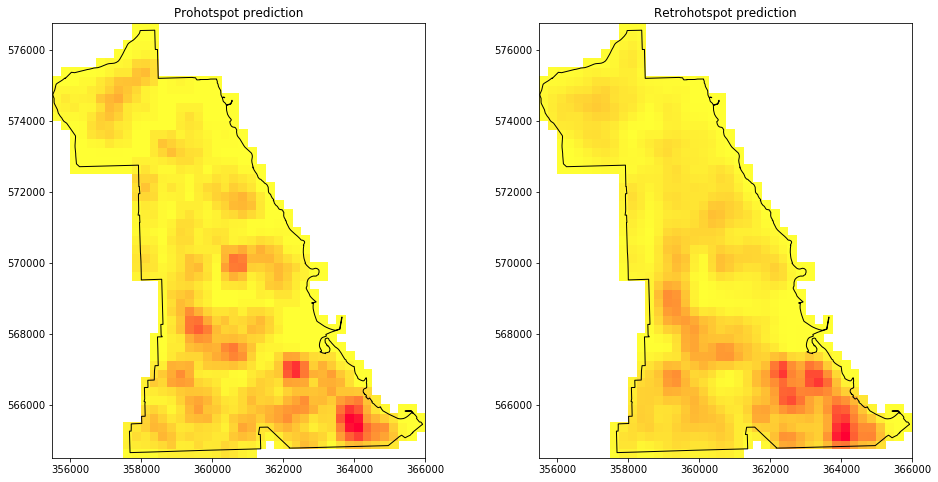

In [70]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    side.to_crs(data.crs).plot(ax=a, color="black", alpha=0)
    
ax[0].pcolormesh(*prohotspot_risk.mesh_data(), prohotspot_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("Prohotspot prediction")
ax[1].pcolormesh(*retrohotspot_risk.mesh_data(), retrohotspot_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].set_title("Retrohotspot prediction")
None

# SeppExp



In [103]:
import open_cp.seppexp
importlib.reload(open_cp.seppexp)

<module 'open_cp.seppexp' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\PredictCode\\open_cp\\seppexp.py'>

In [107]:
seppexp_trainer = open_cp.seppexp.SEPPTrainer(grid=masked_grid)
seppexp_trainer.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]
sepp_exp_predictor = seppexp_trainer.train(cutoff_time = np.datetime64("2011-09-28T00:00"), iterations=1000)
sepp_exp_predictor.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]

In [108]:
sepp_exp_risk = sepp_exp_predictor.predict(np.datetime64("2011-09-28T00:00"))
sepp_exp_risk.mask_with(masked_grid)
sepp_exp_risk_back = sepp_exp_predictor.background_prediction()
sepp_exp_risk_back.mask_with(masked_grid)

### Iterpretting the computed parameters

Remember that the "risk" is a sum of the background rate (see the plot below) and the sum "excitations" which are boosts to the background rate from previous events; these are $\theta \omega e^{-\omega \Delta t}$ where $\Delta t$ is the time since the previous event.

The background rate is around $10^{-4}$ to $10^{-5}$.  We see blw that $\omega \approx 1/50$, or say, about 1 hour (we use "minutes" as the time unit).  Then $\theta \omega \approx 2.10^{-4}$ so around 2 to 20 times the background rate.

Ah, so the problem is that after an hour, the risk decays to $\approx e^{-1} \approx 1/3$.  So after two hours, it decays to $1/9$, and so forth.  In practise, we get no difference between the background rate and the total rate.

In [109]:
sepp_exp_predictor.theta, sepp_exp_predictor.omega, sepp_exp_predictor.theta * sepp_exp_predictor.omega

(0.0098680264766736504, 0.020229709908654202, 0.00019962731299402696)

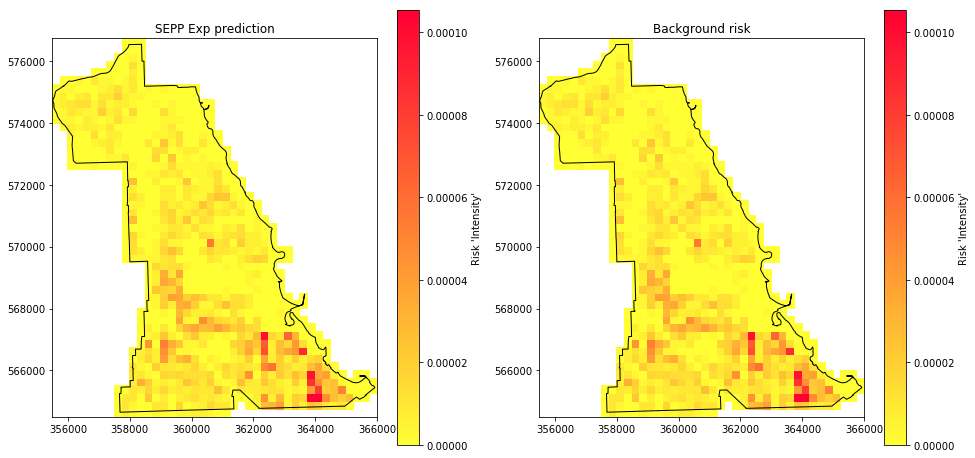

In [110]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    side.to_crs(data.crs).plot(ax=a, color="black", alpha=0)
    
mappable = ax[0].pcolormesh(*sepp_exp_risk.mesh_data(), sepp_exp_risk.intensity_matrix, cmap=yellow_to_red)
cbar = fig.colorbar(mappable, orientation="vertical", ax=ax[0])
cbar.set_label("Risk 'Intensity'")
ax[0].set_title("SEPP Exp prediction")
mappable = ax[1].pcolormesh(*sepp_exp_risk_back.mesh_data(), sepp_exp_risk_back.intensity_matrix, cmap=yellow_to_red)
cbar = fig.colorbar(mappable, orientation="vertical", ax=ax[1])
cbar.set_label("Risk 'Intensity'")
ax[1].set_title("Background risk")

None

# Scoring predictions

For the moment, we shall consider the "hit rate":

- For a given `x` find the top `x`% of grid cells by risk
- For the next day, see how many events we thus capture.

In [40]:
start = np.datetime64("2011-09-28T00:00")
length = np.timedelta64(1, "D")

rates = dict()
while start <= np.datetime64("2012-01-06T00:00"):
    evaluation_points = points[(points.timestamps >= start) & (points.timestamps <= start + length)]
    if evaluation_points.number_data_points == 0:
        continue
    hit_rate = open_cp.evaluation.hit_rates(naive_risk, evaluation_points, range(20))
    rates[start] = hit_rate
    start += length

In [36]:
import importlib
importlib.reload(open_cp.evaluation)

<module 'open_cp.evaluation' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\PredictCode\\open_cp\\evaluation.py'>

In [37]:
start = np.datetime64("2011-09-28T00:00")

best_possible = dict()
while start <= np.datetime64("2012-01-06T00:00"):
    evaluation_points = points[(points.timestamps >= start) & (points.timestamps <= start + length)]
    if evaluation_points.number_data_points == 0:
        continue
    hit_rate = open_cp.evaluation.maximum_hit_rate(masked_grid, evaluation_points, range(20))
    best_possible[start] = hit_rate
    start += length

In [38]:
def compute_stats(rates):
    avg, low, high = [], [], []
    for i in range(20):
        d = [r[i] for r in rates.values()]
        d = np.asarray(d)
        d.sort()
        avg.append(np.average(d) * 100)
        low.append(d[int(len(d)*.25)] * 100)
        high.append(d[int(len(d)*.75)] * 100)
    return avg, low, high

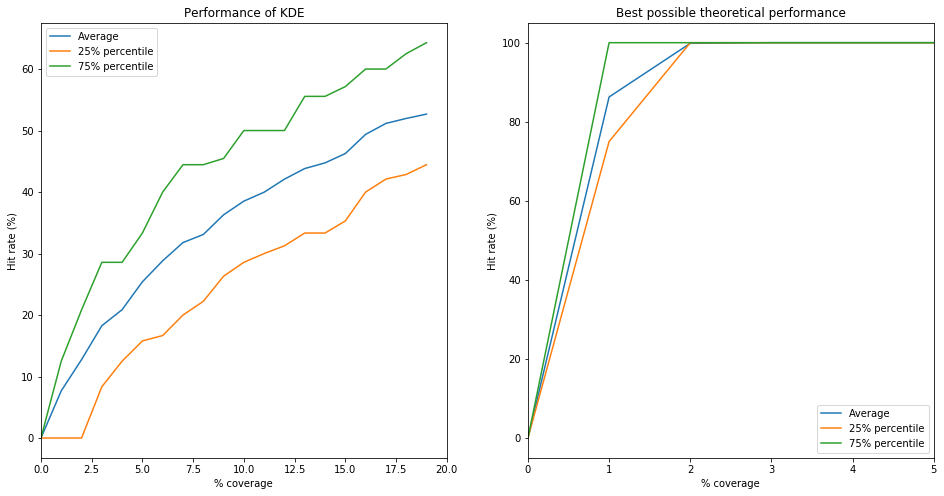

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax, r in zip(axes, [rates, best_possible]):
    avg, low, high = compute_stats(r)
    ax.plot(range(20), avg)
    ax.plot(range(20), low)
    ax.plot(range(20), high)
    ax.legend(["Average", "25% percentile", "75% percentile"])
    ax.set(xlabel="% coverage", ylabel="Hit rate (%)")
    ax.set(xlim=[0,20])
axes[0].set_title("Performance of KDE")
axes[1].set_title("Best possible theoretical performance")
axes[1].set(xlim=[0,5])
None

# Plot the time series

In [42]:
import pandas as pd

In [43]:
frame = pd.DataFrame(rates).T
frame.index.name = "Prediction Date"
frame.columns.name = "% Coverage"
frame.head()

% Coverage,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Prediction Date,,,,,,,,,,,,,,,,,,,,
2011-09-28,0.0,0.285714,0.285714,0.285714,0.285714,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.571429,0.571429,0.571429
2011-09-29,0.0,0.125000,0.208333,0.208333,0.208333,0.291667,0.333333,0.333333,0.333333,0.333333,0.375000,0.500000,0.500000,0.583333,0.625000,0.625000,0.625000,0.625000,0.625000,0.666667
2011-09-30,0.0,0.222222,0.333333,0.333333,0.333333,0.333333,0.555556,0.555556,0.555556,0.555556,0.555556,0.555556,0.555556,0.555556,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
2011-10-01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
2011-10-02,0.0,0.333333,0.333333,0.333333,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


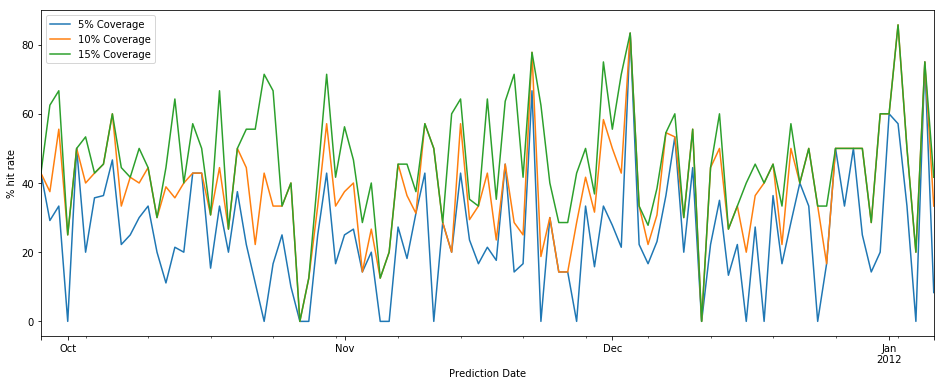

In [44]:
fig, ax = plt.subplots(figsize=(16,6))
(frame[5] * 100).plot(ax=ax)
(frame[10] * 100).plot(ax=ax)
(frame[15] * 100).plot(ax=ax)
ax.set_ylabel("% hit rate")
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
None